# Machine Learning Project

## Introduction

The goal of the project is to recognize if the image is a face or not.

Images are greyscale 36x36 pixels images.

To reach the goal, we will try to train a convolutional neural network.

In [1]:
from deep_learning_project.load_data import basic_load
from deep_learning_project.net import FirstNeuralNetwork, LinearRegressionNetwork, SecondNeuralNetwork
import torch
import matplotlib.pyplot as plt
from torch import nn
from deep_learning_project.trainers import BaseTrainer
import os
import json
import datetime
from tqdm import tqdm

CURRENT_FOLDER = '.'
MODEL_FOLDERS = os.path.join(CURRENT_FOLDER, 'models')

c:\python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

Data is separated in 3 datasets.

Train : to train the ML model.

Valid : to valid the ML model.

Test : to test the ML model.

What is the difference between valid and test datasets. The main differencec is when there are used : valid are used inside the training process but test are used when the training is complete. Why use different datasets to do the same thing (test the generalization of model) ? Some do the validation with the test dataset but it is not scientifically correct because it will include a bias on the model. If we train the model until the test dataset error is the lowest, we effectively train the model for the test dataset... This is why we use two different dataset.

In [2]:
device = "cpu"
parallel = False

if torch.cuda.is_available():
    device = "cuda:0"
    if torch.cuda.device_count() > 1:
        parallel = True


valid_size = 0.2
batch_size = 32

print(f"Running on {device}. Parallel= {parallel}.")

data = basic_load(valid_size=valid_size, batch_size=batch_size, device=device)
train_loader = data[0]
valid_loader = data[1]
test_loader = data[2]
classes = data[3]

Running on cuda:0. Parallel= False.


Feature batch shape: torch.Size([32, 1, 36, 36])
Labels batch shape: torch.Size([32])


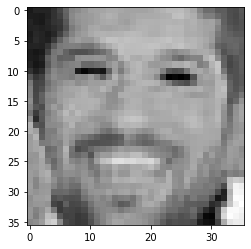

Label: 1


In [3]:
train_features, train_labels = next(iter(data[0]))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze() # from 2d to 1d, works only when the data is 1d [[x]] => [x]
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()

print(f"Label: {label}")

In [4]:
# loading to gpu
for i, data in tqdm(enumerate(train_loader, 0)):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

for i, data in tqdm(enumerate(valid_loader, 0)):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

for i, data in tqdm(enumerate(test_loader, 0)):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

2293it [00:24, 91.98it/s]
574it [00:06, 93.29it/s]
239it [00:02, 93.55it/s]


Printing one image of the training set.


## Initializing the FirstNeuralNetwork network

We initialize the network.

Print the configuration.

Then predict a random input.

---

FirstNeuralNetwork is the neural network given by the teacher.

In [5]:
epochs = 20
learning_rate = 0.01

loss_fn = nn.CrossEntropyLoss()


model = SecondNeuralNetwork()
if parallel:
    model = nn.DataParallel(model)
model.to(device)

SecondNeuralNetwork(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=4800, out_features=48, bias=True)
  (fc2): Linear(in_features=48, out_features=24, bias=True)
  (fc3): Linear(in_features=24, out_features=2, bias=True)
)

In [6]:
random_shit = torch.rand((1, 1, 36, 36), device=device)

logits = model(random_shit)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([1], device='cuda:0')


## Optimizing the network

In [7]:
date_now = datetime.datetime.now()
model_folder_name = os.path.join(MODEL_FOLDERS, date_now.strftime("%Y%m%d_%H%M") + '_' + str(model.__class__.__name__))
os.makedirs(model_folder_name, exist_ok=True)

In [8]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
trainer = BaseTrainer(model, loss_fn, optimizer, checkpoints_path=model_folder_name)

In [9]:
trainer.fit(train_loader=train_loader,
            valid_loader=valid_loader,
            test_loader=test_loader,
            epochs=epochs,
            device=device)

Size of train dataset=73376, train batches=2293, valid dataset=18344, valid batches=574


2293it [00:33, 67.47it/s]


epoch 1 of 20: train_loss: 0.24946, train_accuracy: 89.08%, valid_loss: 0.07970, valid_accuracy: 97.30%, test_loss: 0.48007, test_accuracy: 89.13%


2293it [00:37, 61.52it/s]


epoch 2 of 20: train_loss: 0.05682, train_accuracy: 98.03%, valid_loss: 0.02924, valid_accuracy: 99.01%, test_loss: 0.38155, test_accuracy: 91.39%


2293it [00:35, 63.71it/s]


epoch 3 of 20: train_loss: 0.02533, train_accuracy: 99.12%, valid_loss: 0.01527, valid_accuracy: 99.50%, test_loss: 0.23361, test_accuracy: 94.14%


2293it [00:36, 63.68it/s]


epoch 4 of 20: train_loss: 0.01765, train_accuracy: 99.39%, valid_loss: 0.01341, valid_accuracy: 99.59%, test_loss: 0.22365, test_accuracy: 94.49%


2293it [00:35, 63.73it/s]


epoch 5 of 20: train_loss: 0.01358, train_accuracy: 99.52%, valid_loss: 0.01187, valid_accuracy: 99.61%, test_loss: 0.26249, test_accuracy: 94.22%


2293it [00:35, 63.87it/s]


epoch 6 of 20: train_loss: 0.01161, train_accuracy: 99.59%, valid_loss: 0.00958, valid_accuracy: 99.69%, test_loss: 0.22849, test_accuracy: 94.72%


2293it [00:35, 63.78it/s]


epoch 7 of 20: train_loss: 0.00961, train_accuracy: 99.66%, valid_loss: 0.01022, valid_accuracy: 99.63%, test_loss: 0.18608, test_accuracy: 95.75%


2293it [00:35, 63.78it/s]


epoch 8 of 20: train_loss: 0.00865, train_accuracy: 99.71%, valid_loss: 0.00951, valid_accuracy: 99.68%, test_loss: 0.30833, test_accuracy: 93.97%


2293it [00:35, 63.86it/s]


epoch 9 of 20: train_loss: 0.00759, train_accuracy: 99.73%, valid_loss: 0.01076, valid_accuracy: 99.57%, test_loss: 0.20257, test_accuracy: 95.25%


2293it [00:34, 67.10it/s]


epoch 10 of 20: train_loss: 0.00640, train_accuracy: 99.78%, valid_loss: 0.04068, valid_accuracy: 98.65%, test_loss: 0.40331, test_accuracy: 93.48%


2293it [00:33, 68.67it/s]


epoch 11 of 20: train_loss: 0.00515, train_accuracy: 99.83%, valid_loss: 0.00732, valid_accuracy: 99.74%, test_loss: 0.29250, test_accuracy: 94.77%


2293it [00:33, 69.46it/s]


epoch 12 of 20: train_loss: 0.00482, train_accuracy: 99.83%, valid_loss: 0.00682, valid_accuracy: 99.74%, test_loss: 0.32018, test_accuracy: 94.61%


2293it [00:33, 69.47it/s]


epoch 13 of 20: train_loss: 0.00451, train_accuracy: 99.85%, valid_loss: 0.00671, valid_accuracy: 99.76%, test_loss: 0.30769, test_accuracy: 94.77%


2293it [00:33, 69.29it/s]


epoch 14 of 20: train_loss: 0.00372, train_accuracy: 99.86%, valid_loss: 0.00687, valid_accuracy: 99.79%, test_loss: 0.25167, test_accuracy: 95.50%


2293it [00:33, 69.46it/s]


epoch 15 of 20: train_loss: 0.00334, train_accuracy: 99.91%, valid_loss: 0.00615, valid_accuracy: 99.77%, test_loss: 0.27980, test_accuracy: 95.24%


2293it [00:33, 69.16it/s]


epoch 16 of 20: train_loss: 0.00330, train_accuracy: 99.90%, valid_loss: 0.00727, valid_accuracy: 99.74%, test_loss: 0.23438, test_accuracy: 95.42%


2293it [00:33, 69.29it/s]


epoch 17 of 20: train_loss: 0.00276, train_accuracy: 99.91%, valid_loss: 0.00611, valid_accuracy: 99.78%, test_loss: 0.26224, test_accuracy: 95.58%


2293it [00:33, 69.19it/s]


epoch 18 of 20: train_loss: 0.00233, train_accuracy: 99.92%, valid_loss: 0.00546, valid_accuracy: 99.81%, test_loss: 0.31234, test_accuracy: 95.16%


2293it [00:33, 69.36it/s]


epoch 19 of 20: train_loss: 0.00227, train_accuracy: 99.93%, valid_loss: 0.00540, valid_accuracy: 99.81%, test_loss: 0.24638, test_accuracy: 95.86%


2293it [00:33, 67.78it/s]


epoch 20 of 20: train_loss: 0.00193, train_accuracy: 99.95%, valid_loss: 0.00521, valid_accuracy: 99.80%, test_loss: 0.28579, test_accuracy: 95.49%


In [10]:
best_models = trainer.get_best_model()

stats_file_data = {
    "device": device,
    "network": str(model.__class__.__name__),
    "epochs_number": epochs,
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "train_len_data": len(train_loader.dataset), 
    "test_len_data": len(test_loader.dataset),
    "trainer": str(trainer.__class__.__name__),
    "optimizer": str(optimizer.__class__.__name__),
    "pytorch_version": torch.__version__,
    "loss_function": str(loss_fn.__class__.__name__),
    "best_valid_epoch": best_models['valid']['epoch'],
    "best_valid_accuracy": best_models['valid']['accuracy'],
    "best_valid_loss": best_models['valid']['loss'],
    "best_test_epoch": best_models['test']['epoch'],
    "best_test_accuracy": best_models['test']['accuracy'],
    "best_test_loss": best_models['test']['loss'],
    "performances" : trainer.get_stats(),
}

stats_file_data_json = json.dumps(stats_file_data, indent=4)

stat_file_name = os.path.join(model_folder_name, 'stats.json')
model_file_name = os.path.join(model_folder_name, 'weights.pt')
best_valid_model_file_name = os.path.join(model_folder_name, 'best_valid_weights.pt')
best_test_model_file_name = os.path.join(model_folder_name, 'best_test_weights.pt')

with open(os.path.normpath(stat_file_name), 'w', encoding = 'utf-8') as file:
    file.write(stats_file_data_json)

torch.save(model.state_dict(), model_file_name)
torch.save(best_models['valid']['model'], best_valid_model_file_name)
torch.save(best_models['test']['model'], best_test_model_file_name)

In [11]:
# load model
# ld_model = torch.load('model.pt')

# test_loop(test_loader, ld_model, loss_fn)